In [1]:
import concurrent.futures
import json
import math
import os
import random
from glob import glob
from multiprocessing import Pool

import cv2
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import sknw
import torch
from natsort import natsorted
from skimage.morphology import medial_axis, remove_small_objects
from torch_geometric.data import Data
from tqdm.notebook import tqdm

In [2]:
SIZE_CAP = 200

In [3]:
all_pngs = natsorted(glob("MAP_pngs_DEPTH_tvt/*/*/*.png"))

In [4]:
all_pngs

['MAP_pngs_DEPTH_tvt/test/benign/RP121_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP122_left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP123_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP124_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP126_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP127_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP128_left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP129_right_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP131_left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP135_left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP137_right_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP138_left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP139_Right_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP140_Right_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP142_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP150_right_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP150_right_clean_

In [5]:
benign_pngs = natsorted([x for x in all_pngs if "benign" in x])
malignant_pngs = natsorted([x for x in all_pngs if "malignant" in x])

In [6]:
pairs = list(zip(benign_pngs, malignant_pngs))
for pair in pairs:
    benign, malignant = pair
    assert benign.split("/")[-1].split("_")[0] == malignant.split("/")[-1].split("_")[0]

In [7]:
train_benign_pngs = benign_pngs[: SIZE_CAP // 2]
train_malignant_pngs = malignant_pngs[: SIZE_CAP // 2]
train_pairs = list(zip(benign_pngs, malignant_pngs))

test_benign_pngs = benign_pngs[SIZE_CAP // 2 :]
test_malignant_pngs = malignant_pngs[SIZE_CAP // 2 :]
test_pairs = list(zip(benign_pngs, malignant_pngs))

random.shuffle(train_pairs)
random.shuffle(test_pairs)

for pair in train_pairs:
    benign, malignant = pair
    assert benign.split("/")[-1].split("_")[0] == malignant.split("/")[-1].split("_")[0]
train_pngs = train_benign_pngs + train_malignant_pngs

for pair in test_pairs:
    benign, malignant = pair
    assert benign.split("/")[-1].split("_")[0] == malignant.split("/")[-1].split("_")[0]
test_pngs = test_benign_pngs + test_malignant_pngs

In [8]:
len(all_pngs), len(train_pngs), len(test_pngs)

(156, 156, 0)

In [9]:
train_graph_ids, train_png_paths = list(zip(*list(enumerate(train_pngs))))
train_png_paths = [x.split("/")[-1] for x in train_png_paths]
try:
    test_graph_ids, test_png_paths = list(zip(*list(enumerate(test_pngs))))
    test_png_paths = [x.split("/")[-1] for x in test_png_paths]
except ValueError as e:
    test_graph_ids = []
    test_png_paths = []

In [10]:
train_graph_id_map = dict(zip(train_png_paths, train_graph_ids))
test_graph_id_map = dict(zip(test_png_paths, test_graph_ids))

In [11]:
train_graph_id_map

{'RP121_Left_after_DL.png': 0,
 'RP122_left_after_DL.png': 1,
 'RP123_Left_after_DL.png': 2,
 'RP124_Left_after_DL.png': 3,
 'RP126_Left_after_DL.png': 4,
 'RP127_Left_after_DL.png': 5,
 'RP128_left_after_DL.png': 6,
 'RP129_right_after_DL.png': 7,
 'RP131_left_after_DL.png': 8,
 'RP135_left_after_DL.png': 9,
 'RP137_right_after_DL.png': 10,
 'RP138_left_after_DL.png': 11,
 'RP139_Right_after_DL.png': 12,
 'RP140_Right_after_DL.png': 13,
 'RP142_Left_after_DL.png': 14,
 'RP150_right_after_DL.png': 15,
 'RP150_right_clean_after_DL.png': 16,
 'RP151_right_after_DL.png': 17,
 'RP151_right_clean_after_DL.png': 18,
 'RP152_right_after_DL.png': 19,
 'RP152_right_clean_after_DL.png': 20,
 'RP154_left_after_DL.png': 21,
 'RP154_left_clean_after_DL.png': 22,
 'WS025_right_after_DL.png': 23,
 'WS026_right_after_DL.png': 24,
 'RP059_paL_after_DL.png': 25,
 'RP060_left_after_DL.png': 26,
 'RP061_right_after_DL.png': 27,
 'RP062_left_after_DL.png': 28,
 'RP063_right_after_DL.png': 29,
 'RP065_right

In [12]:
def merge_edges(graph, label_start=0):
    while True:
        nodes_to_remove = []
        for node, degree in graph.degree():
            if degree == 2:
                neighbors = list(graph.neighbors(node))
                if len(neighbors) == 2:
                    # check neighbors degrees
                    n1, n2 = neighbors
                    n1_degree = graph.degree(n1)
                    n2_degree = graph.degree(n2)
                    if n1_degree <= 2 and n2_degree <= 2:
                        nodes_to_remove.append(node)
        if not nodes_to_remove:
            break
        for node in nodes_to_remove:
            neighbors = list(graph.neighbors(node))
            if len(neighbors) == 2:
                # Merge the 'pts' attributes of the two edges
                pts_0 = graph[neighbors[0]][node]["pts"]
                pts_1 = graph[node][neighbors[1]]["pts"]
                weight_0 = graph[neighbors[0]][node].get("weight", 1)
                weight_1 = graph[node][neighbors[1]].get("weight", 1)
                # Check the order of points to ensure they form a continuous path
                if np.linalg.norm(pts_0[-1] - pts_1[0]) > np.linalg.norm(
                    pts_0[-1] - pts_1[-1]
                ):
                    pts_1 = pts_1[::-1]
                pts = np.concatenate((pts_0, pts_1))
                weight = weight_0 + weight_1
                # Store the path information in a new attribute 'path'
                path_0 = graph[neighbors[0]][node].get("path", [neighbors[0]])
                path_1 = graph[node][neighbors[1]].get("path", [node, neighbors[1]])
                path = path_0 + path_1[1:]
                graph.add_edge(
                    neighbors[0], neighbors[1], pts=pts, path=path, weight=weight
                )
                graph.remove_node(node)
    graph = nx.convert_node_labels_to_integers(graph, first_label=label_start)
    return graph

In [13]:
def png_to_sknw(
    png_path: str, label_start=0, merge=True
) -> tuple[nx.Graph, np.ndarray]:
    """
    Convert a PNG image to a skeletonized graph.

    Args:
        png_path (str): The path to the PNG image.

    Returns:
        tuple[nx.Graph, np.ndarray]: A tuple containing the skeletonized graph and the cleaned skeleton image.
    """
    img = cv2.imread(png_path, 0)
    # _, map_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh_val, _ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh_val = thresh_val + ((thresh_val**0.5) * math.log2(thresh_val))
    map_thresh = img > thresh_val

    skel, _ = medial_axis(map_thresh, return_distance=True)
    skel_clean = remove_small_objects(skel, connectivity=5, min_size=20)
    skel_graph = sknw.build_sknw(skel_clean)

    if merge:
        initial_node_count = len(skel_graph.nodes)
        skel_graph = merge_edges(skel_graph, label_start)
        final_node_count = len(skel_graph.nodes)
        print(f"Reduced node count from {initial_node_count} to {final_node_count}")

    return skel_graph, skel_clean

thresh_val: 136.54504387613554, 


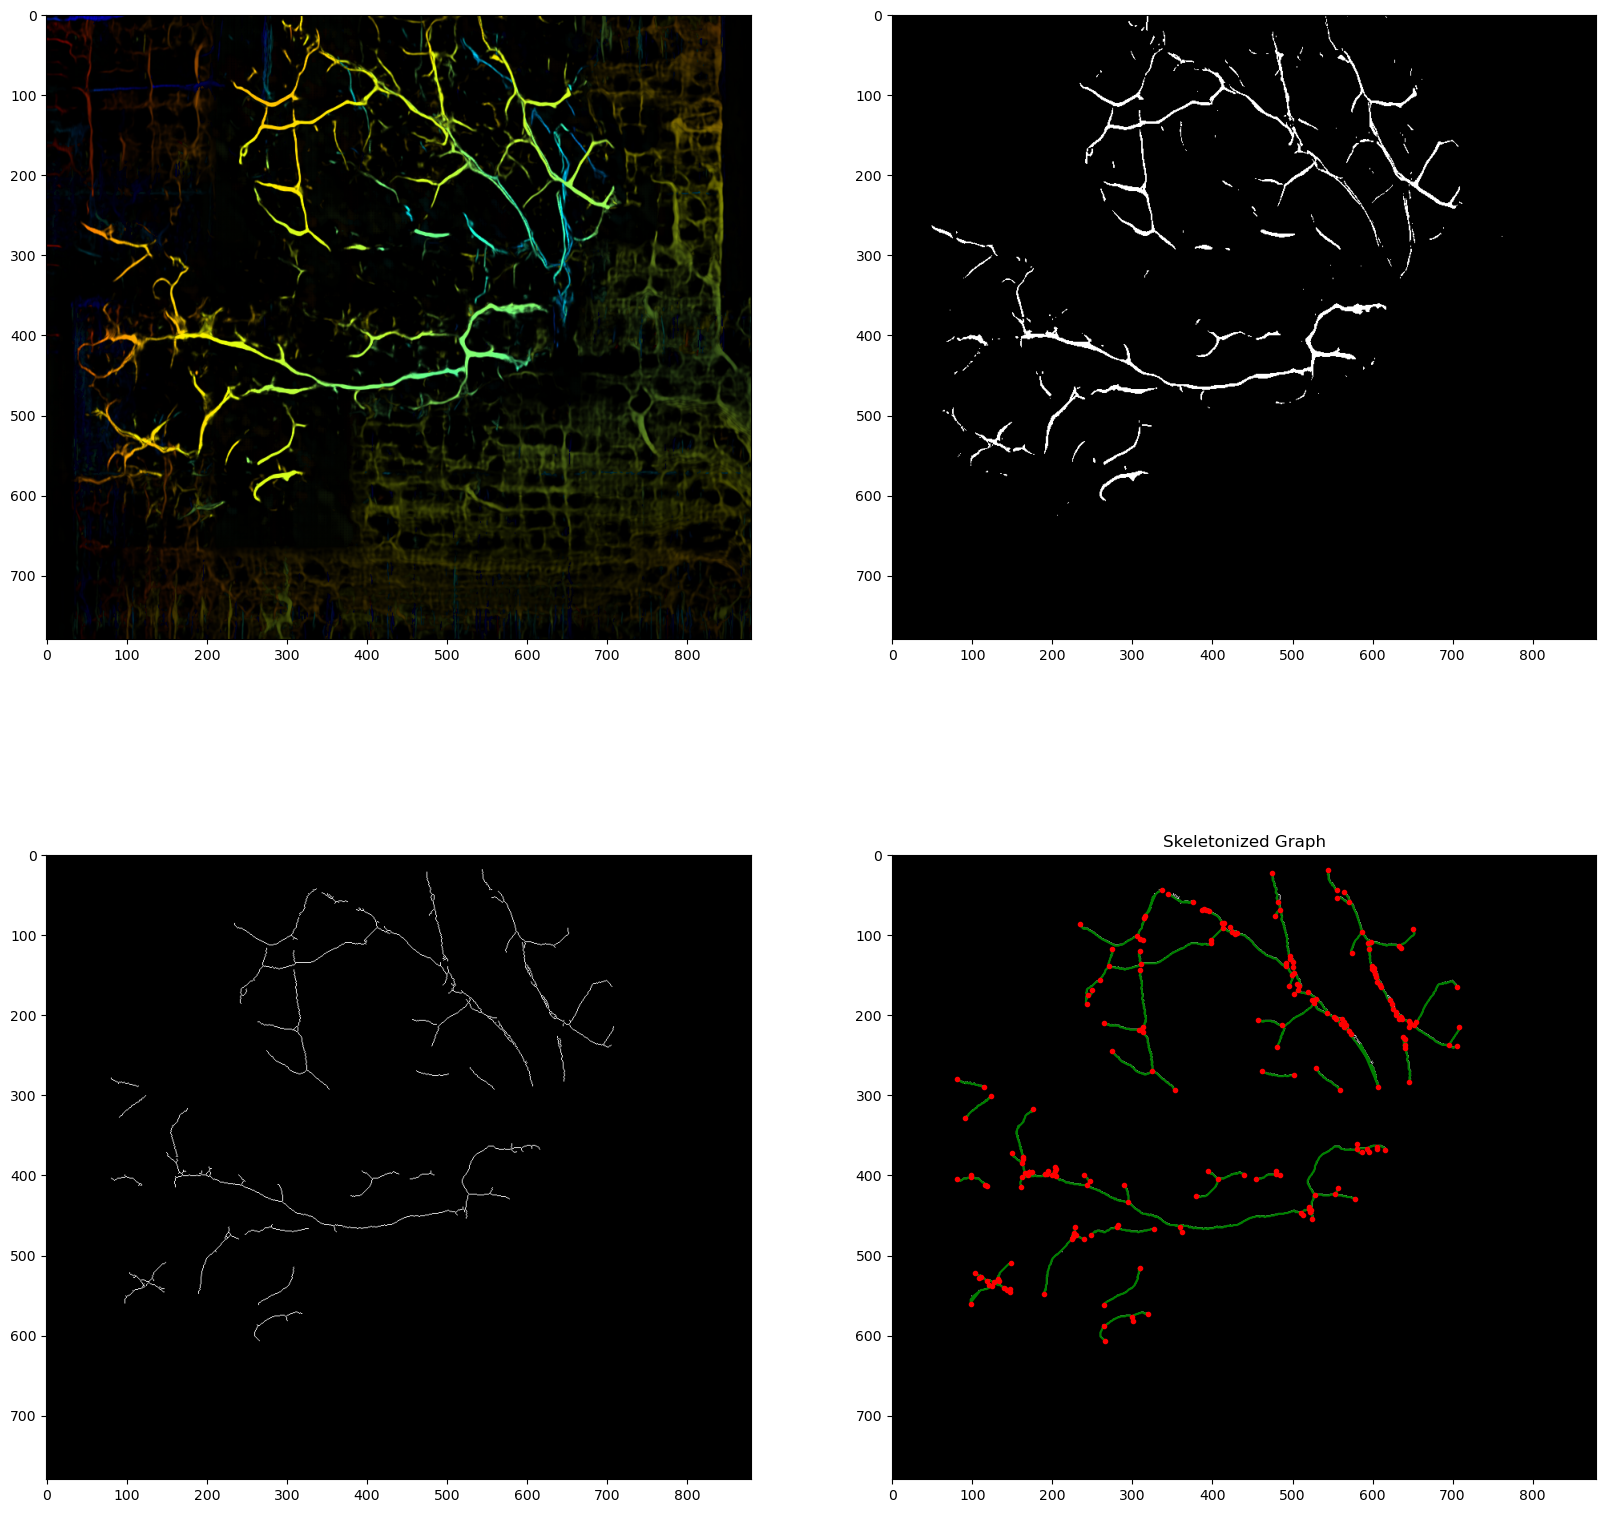

In [14]:
path_ = all_pngs[2]

img = cv2.imread(path_)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

thresh_val, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh_val = thresh_val + ((thresh_val**0.5) * math.log2(thresh_val))

print(f"thresh_val: {thresh_val}, ")

map_thresh = gray > thresh_val
# map_thresh = remove_small_objects(map_thresh, connectivity=5, min_size=32)


skel, _ = medial_axis(map_thresh, return_distance=True)
skel_clean = remove_small_objects(skel, connectivity=5, min_size=30)

skel_graph = merge_edges(sknw.build_sknw(skel_clean))


plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.imshow(img_rgb)
plt.subplot(222)
plt.imshow(map_thresh, cmap="gray")
plt.subplot(223)
plt.imshow(skel_clean, cmap="gray")
plt.subplot(224)
plt.imshow(skel_clean, cmap="gray")
# draw edges by pts
for s, e in skel_graph.edges():
    ps = skel_graph[s][e]["pts"]
    plt.plot(ps[:, 1], ps[:, 0], "green")
# draw node by o
nodes = skel_graph.nodes()
ps = np.array([nodes[i]["o"] for i in nodes])
plt.plot(ps[:, 1], ps[:, 0], "r.")
plt.title("Skeletonized Graph")
plt.show()

In [15]:
def visualize(png_path, merge=True):
    skel_graph, skel_clean = png_to_sknw(png_path, merge=merge)

    img = cv2.imread(png_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20, 20))
    plt.subplot(131)
    plt.imshow(img)
    plt.title("Original Image")
    plt.subplot(132)
    plt.imshow(skel_clean, cmap="gray")
    plt.subplot(133)
    plt.imshow(skel_clean, cmap="gray")
    # draw edges by pts
    for s, e in skel_graph.edges():
        ps = skel_graph[s][e]["pts"]
        plt.plot(ps[:, 1], ps[:, 0], "green")
    # draw node by o
    nodes = skel_graph.nodes()
    ps = np.array([nodes[i]["o"] for i in nodes])
    plt.plot(ps[:, 1], ps[:, 0], "r.")
    plt.title("Skeletonized Graph")
    plt.show()

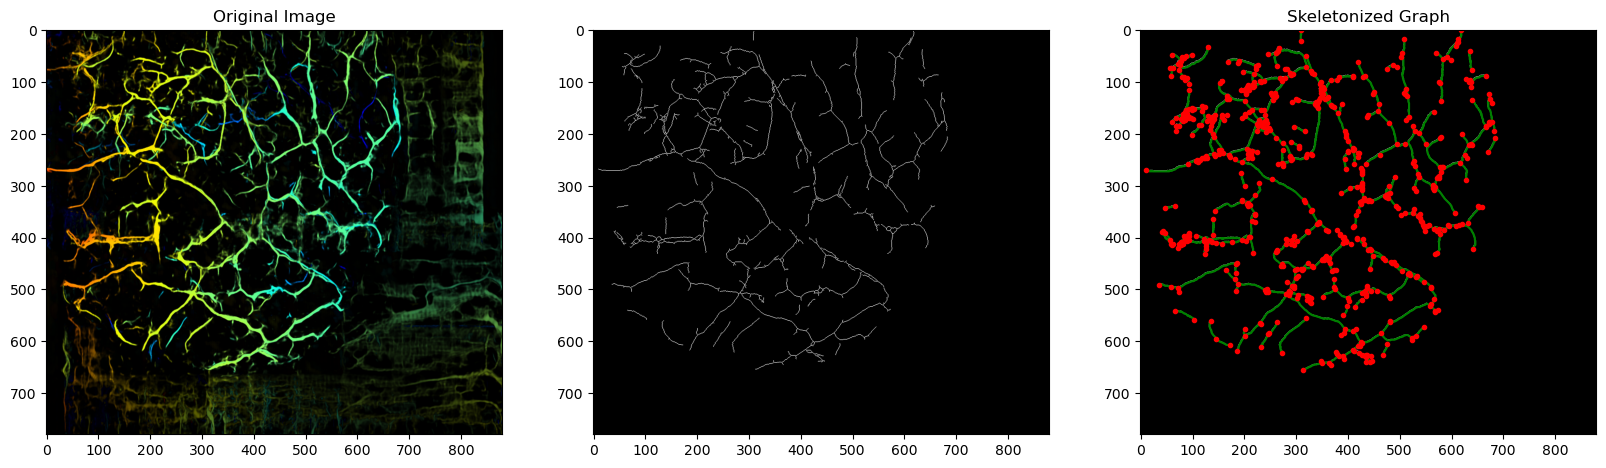

In [16]:
visualize(all_pngs[0], False)

Reduced node count from 661 to 643


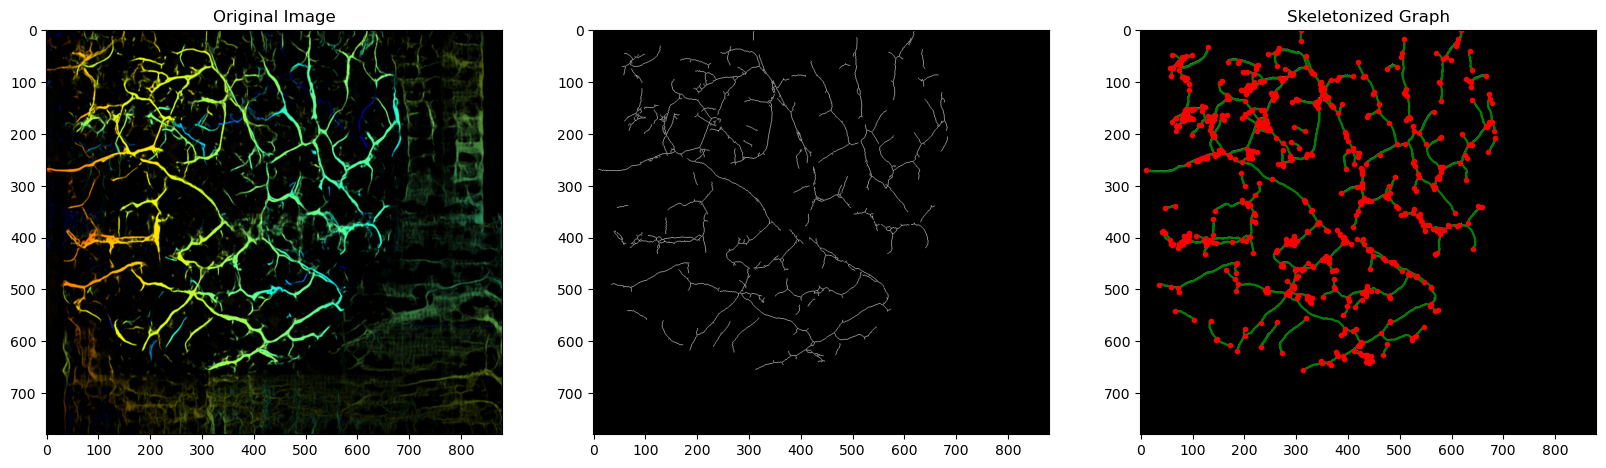

In [17]:
visualize(all_pngs[0], True)

Reduced node count from 634 to 613


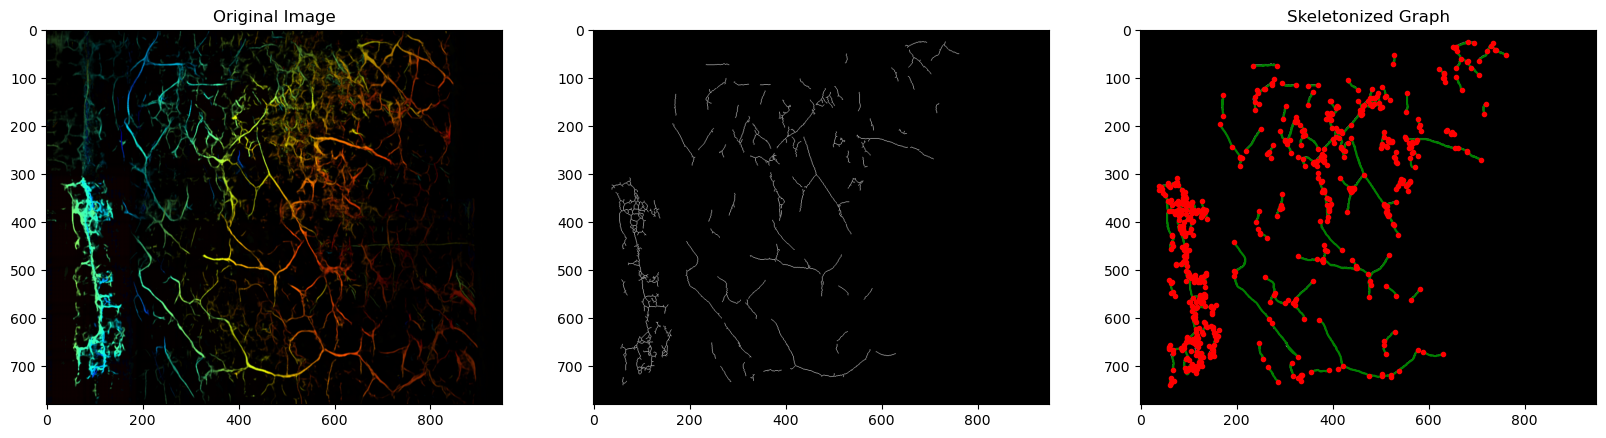

In [18]:
visualize(all_pngs[1])

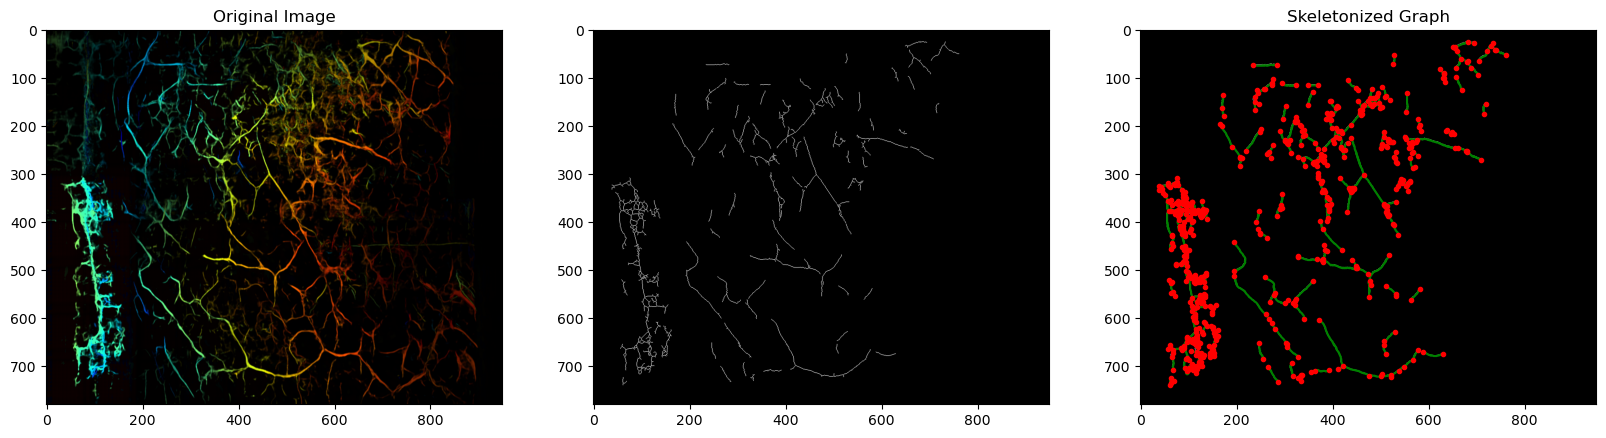

In [19]:
visualize(all_pngs[1], False)

Reduced node count from 267 to 244


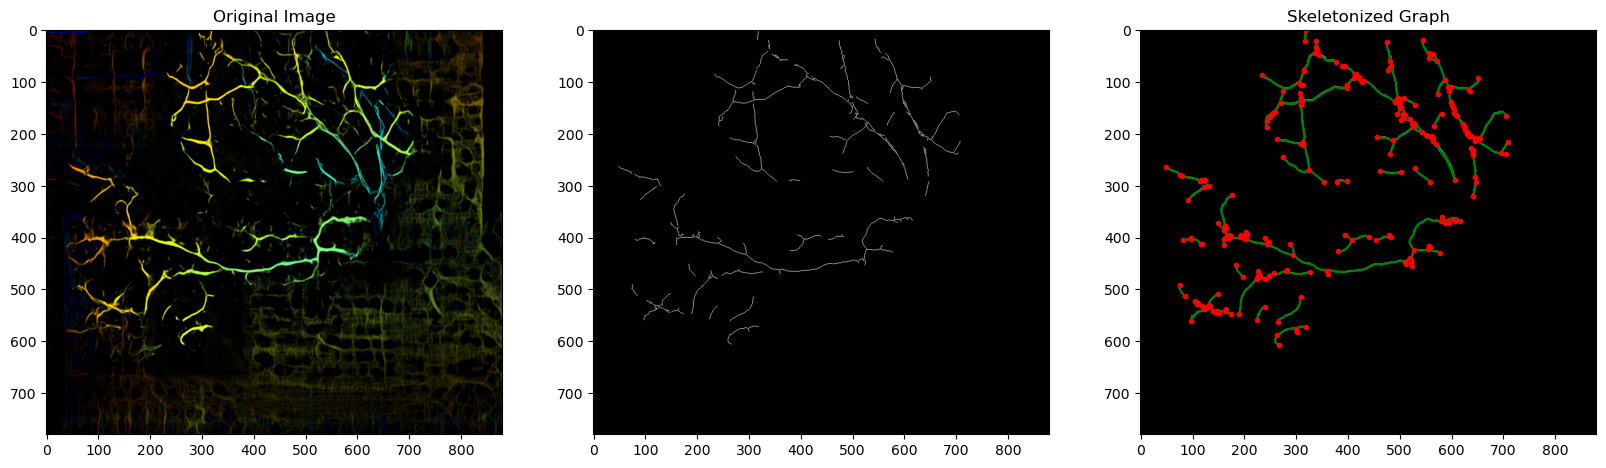

In [20]:
visualize(all_pngs[2])

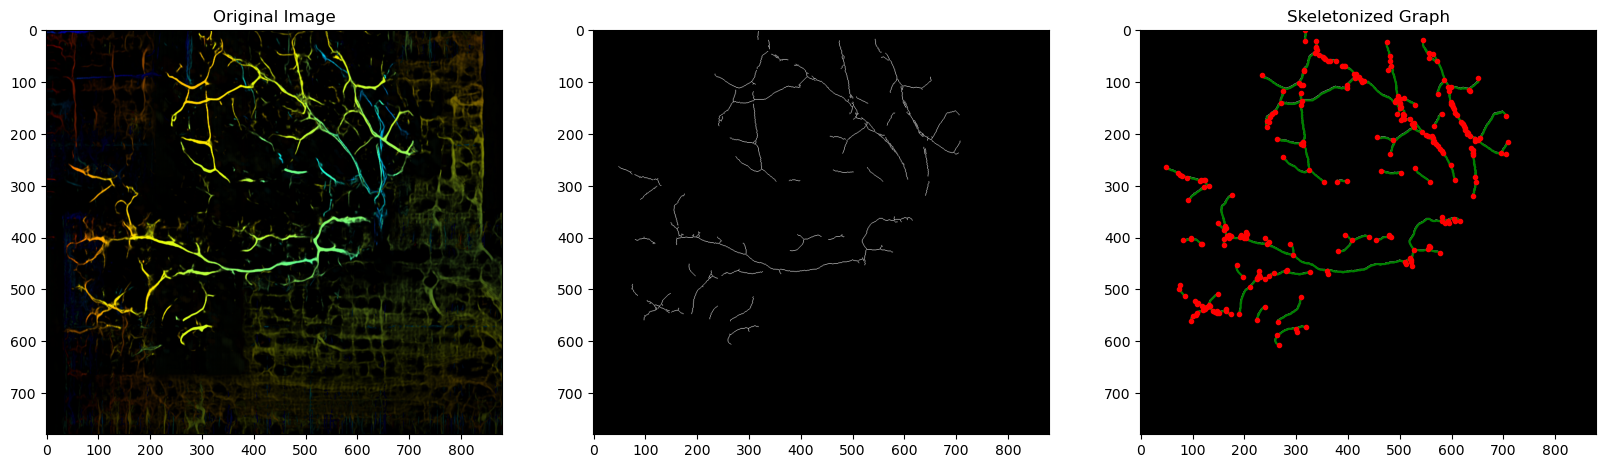

In [21]:
visualize(all_pngs[2], False)

In [22]:
edge_count = 0
node_count = 0

train_edges = []
train_graph_ids = []
train_graph_labels = []
train_node_labels = []
train_node_attributes = []
train_edge_attributes = []
tuples = []
for graph_id, png_path in tqdm(enumerate(train_pngs), total=len(train_pngs)):
    if "benign" in png_path:
        graph_label = 0
    else:
        graph_label = 1
    tuples.append(
        (graph_id, png_path.split("/")[-1], png_path.split("/")[-2], graph_label)
    )
    train_graph_labels.append(graph_label)

    img_rgb = cv2.imread(png_path)

    skel_graph, skel_clean = png_to_sknw(png_path, label_start=node_count)

    # DS_A
    graph_edges = skel_graph.edges()
    graph_edges = np.array(graph_edges)

    graph_edge_weights = np.array(
        [skel_graph[u][v].get("weight", 1) for u, v in graph_edges]
    )

    graph_edge_s = graph_edges.T[0].copy()
    graph_edge_e = graph_edges.T[1].copy()
    graph_edges_rev = np.array([graph_edge_e, graph_edge_s]).T
    graph_edge_rev_weights = graph_edge_weights.copy()

    graph_edges = np.concatenate([graph_edges, graph_edges_rev], axis=0)
    graph_edge_weights = np.concatenate([graph_edge_weights, graph_edge_rev_weights])

    train_edges.append(graph_edges)
    train_edge_attributes.append(graph_edge_weights)

    graph_id_arr = np.repeat(graph_id, len(skel_graph.nodes()))
    train_graph_ids.append(graph_id_arr)

    # for each node find the rgb value of the corresponding pixel and one hot encode the index of the channel with the highest value
    node_label_arr = np.array(
        [
            img_rgb[int(node[0]), int(node[1])]
            for node in nx.get_node_attributes(skel_graph, "o").values()
        ]
    )
    node_label_arr = np.argmax(node_label_arr, axis=1)
    train_node_labels.append(node_label_arr)

    # for each image load the corresponding intensity encoded image as grayscale
    # MAP_pngs_DEPTH_tvt/val/malignant/RP115_Right_after_DL.png -> MAP_pngs_enc/val/malignant/RP115_Right_after_DL.png
    img_intensity_gray = cv2.imread(
        png_path.replace("MAP_pngs_DEPTH_tvt", "MAP_pngs_enc"), 0
    )
    # for each node find the value of the corresponding pixel and add it to the node attribute array
    node_attribute_arr = np.array(
        [
            img_intensity_gray[int(node[0]), int(node[1])]
            for node in nx.get_node_attributes(skel_graph, "o").values()
        ]
    )
    train_node_attributes.append(node_attribute_arr)

    edge_count += len(skel_graph.edges())
    node_count += len(skel_graph.nodes())

if not os.path.exists(f"train/BREAST/BREAST/raw"):
    os.makedirs(f"train/BREAST/BREAST/raw")

train_edges = np.concatenate(train_edges, axis=0)
train_edges = pd.DataFrame(train_edges, columns=["source", "target"]) + 1
train_edges.to_csv(f"train/BREAST/BREAST/raw/BREAST_A.txt", index=False, header=False)

train_graph_ids = np.concatenate(train_graph_ids, axis=0)
train_graph_ids = pd.DataFrame(train_graph_ids, columns=["graph_id"]) + 1
train_graph_ids.to_csv(
    f"train/BREAST/BREAST/raw/BREAST_graph_indicator.txt", index=False, header=False
)

train_graph_labels = pd.DataFrame(train_graph_labels, columns=["graph_label"])
train_graph_labels.to_csv(
    f"train/BREAST/BREAST/raw/BREAST_graph_labels.txt", index=False, header=False
)

train_node_labels = np.concatenate(train_node_labels, axis=0)
train_node_labels = pd.DataFrame(train_node_labels, columns=["node_label"])
train_node_labels.to_csv(
    f"train/BREAST/BREAST/raw/BREAST_node_labels.txt", index=False, header=False
)

train_node_attributes = np.concatenate(train_node_attributes, axis=0).astype(float)
train_node_attributes = pd.DataFrame(train_node_attributes, columns=["node_attribute"])
train_node_attributes.to_csv(
    f"train/BREAST/BREAST/raw/BREAST_node_attributes.txt", index=False, header=False
)

train_edge_attributes = np.concatenate(train_edge_attributes, axis=0).astype(float)
train_edge_attributes = pd.DataFrame(train_edge_attributes, columns=["edge_attribute"])
train_edge_attributes.to_csv(
    f"train/BREAST/BREAST/raw/BREAST_edge_attributes.txt", index=False, header=False
)

with open(f"train/BREAST/BREAST/raw/graph_id_map.json", "w") as f:
    json.dump(train_graph_id_map, f)

pd.DataFrame(
    tuples, columns=["graph_id", "png_path", "path_label", "graph_label"]
).to_csv("train/id_path_label.csv", index=False)

  0%|          | 0/156 [00:00<?, ?it/s]

Reduced node count from 657 to 638
Reduced node count from 633 to 614
Reduced node count from 265 to 245
Reduced node count from 507 to 481
Reduced node count from 174 to 168
Reduced node count from 494 to 480
Reduced node count from 289 to 276
Reduced node count from 902 to 885
Reduced node count from 586 to 564
Reduced node count from 476 to 447
Reduced node count from 943 to 907
Reduced node count from 641 to 633
Reduced node count from 537 to 508
Reduced node count from 691 to 655
Reduced node count from 597 to 546
Reduced node count from 312 to 296
Reduced node count from 466 to 441
Reduced node count from 389 to 376
Reduced node count from 447 to 440
Reduced node count from 187 to 182
Reduced node count from 338 to 325
Reduced node count from 159 to 147
Reduced node count from 316 to 297
Reduced node count from 354 to 333
Reduced node count from 653 to 619
Reduced node count from 263 to 244
Reduced node count from 313 to 295
Reduced node count from 184 to 178
Reduced node count f

In [23]:
edge_count = 0
node_count = 0

test_edges = []
test_graph_ids = []
test_graph_labels = []
test_node_labels = []
test_node_attributes = []
test_edge_attributes = []
tuples = []
for graph_id, png_path in tqdm(enumerate(test_pngs), total=len(test_pngs)):
    if "benign" in png_path:
        graph_label = 0
    else:
        graph_label = 1
    tuples.append(
        (graph_id, png_path.split("/")[-1], png_path.split("/")[-2], graph_label)
    )
    test_graph_labels.append(graph_label)

    img_rgb = cv2.imread(png_path)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    # _, map_thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh_val, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh_val = 1.5 * thresh_val
    map_thresh = gray > thresh_val

    skel, distance = medial_axis(map_thresh, return_distance=True)
    skel_clean = remove_small_objects(skel, connectivity=10, min_size=10)

    skel_graph = sknw.build_sknw(skel_clean)

    # # Remove nodes with less than 3 edges
    # nodes_to_remove = [node for node, degree in skel_graph.degree() if degree < 2]
    # skel_graph.remove_nodes_from(nodes_to_remove)

    skel_graph = nx.convert_node_labels_to_integers(skel_graph, first_label=node_count)

    # DS_A
    graph_edges = skel_graph.edges()
    graph_edges = np.array(graph_edges)

    graph_edge_weights = np.array(
        [skel_graph[u][v].get("weight", 1) for u, v in graph_edges]
    )

    graph_edge_s = graph_edges.T[0].copy()
    graph_edge_e = graph_edges.T[1].copy()
    graph_edges_rev = np.array([graph_edge_e, graph_edge_s]).T
    graph_edge_rev_weights = graph_edge_weights.copy()

    graph_edges = np.concatenate([graph_edges, graph_edges_rev], axis=0)
    graph_edge_weights = np.concatenate([graph_edge_weights, graph_edge_rev_weights])

    test_edges.append(graph_edges)
    test_edge_attributes.append(graph_edge_weights)

    graph_id_arr = np.repeat(graph_id, len(skel_graph.nodes()))
    test_graph_ids.append(graph_id_arr)

    # for each node find the rgb value of the corresponding pixel and one hot encode the index of the channel with the highest value
    node_label_arr = np.array(
        [
            img_rgb[int(node[0]), int(node[1])]
            for node in nx.get_node_attributes(skel_graph, "o").values()
        ]
    )
    node_label_arr = np.argmax(node_label_arr, axis=1)
    test_node_labels.append(node_label_arr)

    # for each image load the corresponding intensity encoded image as grayscale
    # MAP_pngs_DEPTH_tvt/val/malignant/RP115_Right_after_DL.png -> MAP_pngs_enc/val/malignant/RP115_Right_after_DL.png
    img_intensity_gray = cv2.imread(
        png_path.replace("MAP_pngs_DEPTH_tvt", "MAP_pngs_enc"), 0
    )
    # for each node find the value of the corresponding pixel and add it to the node attribute array
    node_attribute_arr = np.array(
        [
            img_intensity_gray[int(node[0]), int(node[1])]
            for node in nx.get_node_attributes(skel_graph, "o").values()
        ]
    )
    test_node_attributes.append(node_attribute_arr)

    edge_count += len(skel_graph.edges())
    node_count += len(skel_graph.nodes())

if not os.path.exists(f"test/BREAST/BREAST/raw"):
    os.makedirs(f"test/BREAST/BREAST/raw")

test_edges = np.concatenate(test_edges, axis=0)
test_edges = pd.DataFrame(test_edges, columns=["source", "target"]) + 1
test_edges.to_csv(f"test/BREAST/BREAST/raw/BREAST_A.txt", index=False, header=False)

test_graph_ids = np.concatenate(test_graph_ids, axis=0)
test_graph_ids = pd.DataFrame(test_graph_ids, columns=["graph_id"]) + 1
test_graph_ids.to_csv(
    f"test/BREAST/BREAST/raw/BREAST_graph_indicator.txt", index=False, header=False
)

test_graph_labels = pd.DataFrame(test_graph_labels, columns=["graph_label"])
test_graph_labels.to_csv(
    f"test/BREAST/BREAST/raw/BREAST_graph_labels.txt", index=False, header=False
)

test_node_labels = np.concatenate(test_node_labels, axis=0)
test_node_labels = pd.DataFrame(test_node_labels, columns=["node_label"])
test_node_labels.to_csv(
    f"test/BREAST/BREAST/raw/BREAST_node_labels.txt", index=False, header=False
)

test_node_attributes = np.concatenate(test_node_attributes, axis=0).astype(float)
test_node_attributes = pd.DataFrame(test_node_attributes, columns=["node_attribute"])
test_node_attributes.to_csv(
    f"test/BREAST/BREAST/raw/BREAST_node_attributes.txt", index=False, header=False
)

test_edge_attributes = np.concatenate(test_edge_attributes, axis=0).astype(float)
test_edge_attributes = pd.DataFrame(test_edge_attributes, columns=["edge_attribute"])
test_edge_attributes.to_csv(
    f"test/BREAST/BREAST/raw/BREAST_edge_attributes.txt", index=False, header=False
)

with open(f"test/BREAST/BREAST/raw/graph_id_map.json", "w") as f:
    json.dump(test_graph_id_map, f)

pd.DataFrame(
    tuples, columns=["graph_id", "png_path", "path_label", "graph_label"]
).to_csv("test/id_path_label.csv", index=False)

0it [00:00, ?it/s]

ValueError: need at least one array to concatenate

In [ ]:
#  copy test_pngs to test/pngs

if not os.path.exists(f"test/pngs"):
    os.makedirs(f"test/pngs")

for png_path in test_pngs:
    os.system(f"cp {png_path} test/pngs")

In [ ]:
na_df = pd.read_csv("train/BREAST/BREAST/raw/BREAST_node_attributes.txt", header=None)

In [ ]:
na_df.describe()

In [ ]:
na_df = pd.read_csv("PROTEINS_node_attributes.txt", header=None)

In [ ]:
na_df.describe()